#### Import Module

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup as bs
import requests

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import tweepy as tp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from textblob import TextBlob

# Import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikhael.bratanata\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


# Web Scraping: IMDB

In [2]:
# Define html parser from beautiful soup
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = bs(response.text, 'html.parser')

In [3]:
# Get the content
movies = soup.select('td.titleColumn')
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [4]:
imdb = []

# Store each item into 'data' dictionary, then put those into 'imdb' list
for index in range(0, len(movies)):
    # Seperate movie into: 'title', 'rating'
    movie_string = movies[index].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(index))+1:-7]
    data = {"movie_title": movie_title,
            "rating": float(ratings[index])}
    imdb.append(data)

In [5]:
# Convert from list to dataframe
df = pd.DataFrame(imdb)

In [6]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
df['rating_group'] = df['rating'].apply(lambda x: 'Exceptional' if x > 8.5 else 'Good')

In [8]:
df

,movie_title,rating,rating_group
0,The Shawshank Redemption,9.222151,Exceptional
1,The Godfather,9.148883,Exceptional
2,The Godfather: Part II,8.981222,Exceptional
3,The Dark Knight,8.967951,Exceptional
4,12 Angry Men,8.921862,Exceptional
...,...,...,...
245,Mou gaan dou,8.004474,Good
246,La battaglia di Algeri,8.004030,Good
247,El ángel exterminador,8.003580,Good
248,Tenkû no shiro Rapyuta,8.002836,Good


In [9]:
# Count ratings 
score = df.groupby(['rating_group'])['rating_group'].count()

# Create a dataframe for displaying chart
chart = pd.DataFrame(score)
chart['rating'] = chart['rating_group']
chart.drop(['rating_group'], axis = 1, inplace = True )
chart = chart.reset_index()

# Make percentage for each rating_group category
chart['percent'] = chart['rating']/chart['rating'].sum()
chart

,rating_group,rating,percent
0,Exceptional,33,0.132
1,Good,217,0.868


In [10]:
chart.head()

,rating_group,rating,percent
0,Exceptional,33,0.132
1,Good,217,0.868


Text(0.5, 1.0, 'The distribution of Top 250 movies')

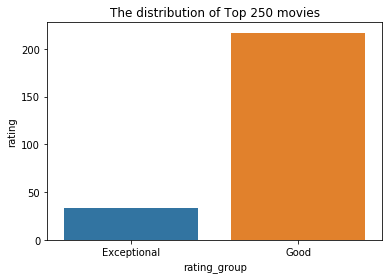

In [11]:
# Make a Bar Chart
ax = sns.barplot(x= 'rating_group', y='rating', data=chart)
ax.set_title('The distribution of Top 250 movies') 

# API: Twitter

## SECTION A: Data Preparation

### Step A.1.: Getting the authentication credentials

In [12]:
# Initialize api instance
consumer_key = '9aKvUazvVZmzHHPMtD8sON1t6'
consumer_secret = 'IHlmrjpn7YuKnK9XkabgQsCzlmGHhR7wtupFgd8mkXBoDHoWMW'
access_token = '25478378-hLGQS5p5QA03jya7WBPQQgknKc3uh79KfNLCOamtZ'
access_token_secret = 'tROHVOsPa4XCTY4fbGeQjh3BgJm9bgdV09mCVcHhC3xh6'

# Authentication
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tp.API(auth)

In [ ]:
api = tp.API(auth, wait_on_rate_limit=True)

### Step A.2.: Getting a Dataset from Twitter

In [141]:
# Get tweets 
tweets = tp.Cursor(api.search,q="#DataScience",lang="en").items(1500)
result = []
for tweet in  tweets :
    result.append(tweet)

### Step A.3.: Extract Tweet to pandas dataframe

In [142]:
# Extract tweet to the pandas dataframe
def tweets_df(results):
    id_list = [tweet.id for tweet  in results]
    df = pd.DataFrame(id_list, columns = ["id"])
    
    df["text"] = [tweet.text for tweet in results]
    df["created_at"] = [tweet.created_at for tweet in results]
    df["retweet_count"] = [tweet.retweet_count for tweet in results]
    df["user_screen_name"] = [tweet.author.screen_name for tweet in results]
    df["user_followers_count"] = [tweet.author.followers_count for tweet in results]
    df["user_location"] = [tweet.author.location for tweet in results]
    df["Hashtags"] = [tweet.entities.get('hashtags') for tweet in results]

    return df

In [143]:
# Use the function to get dataframe of the tweet
df = tweets_df(result)
df.head()

,id,text,created_at,retweet_count,user_screen_name,user_followers_count,user_location,Hashtags
0,1189852190745210880,RT @reach2ratan: VPN Services Now Under Closer...,2019-10-31 10:30:43,1,BorskiKay,46,West Haven CT,"[{'text': 'CyberSecurity', 'indices': [100, 11..."
1,1189852171187171329,Where do you find your datasets? https://t.co/...,2019-10-31 10:30:38,0,ericcire,72,In a greenhouse,"[{'text': 'datascience', 'indices': [57, 69]}]"
2,1189852169865969669,What is the name of this type of Data Visualiz...,2019-10-31 10:30:38,0,ericcire,72,In a greenhouse,[]
3,1189852168527978496,Best schools in the US for Master's in Social ...,2019-10-31 10:30:38,0,ericcire,72,In a greenhouse,"[{'text': 'datascience', 'indices': [84, 96]}]"
4,1189852167408107521,250+ Machine Learning and Deep Learning Resour...,2019-10-31 10:30:37,0,ericcire,72,In a greenhouse,"[{'text': 'datascience', 'indices': [106, 118]}]"


In [144]:
# Drop duplicate tweet 
g_unique = set()
for item in df['text']:
        g_unique.add(item) # ensures the element will only be copied if not already in the set
tweet = []
for item in g_unique:
    tweet.append(item)
    dataframe = pd.DataFrame(tweet,columns = ['text'])

In [145]:
len(dataframe)

263

In [146]:
dataframe

,text
0,RT @Ronald_vanLoon: How Data Changed the World...
1,RT @Datascience__: Natural Language Processing...
2,RT @ipfconline1: Using #MachineLearning in Ven...
3,"RT @into_AI: Livspace forays Into Singapore, S..."
4,K-Medoids Clustering on Iris Data Set https://...
...,...
258,RT @VergeLabsAI: Resources for Forecasting 🔮 -...
259,RT @tsdataclinic: Data Clinic is looking for a...
260,RT @New_To_Dave: *Job Alert* Our partners in @...
261,What is the name of this type of Data Visualiz...


## SECTION B: Data Preprocessing

### Step B.1.: Basic Text Pre-processing 

### 1. Lower casing

In [147]:
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
dataframe['text'].head()

0    rt @ronald_vanloon: how data changed the world...
1    rt @datascience__: natural language processing...
2    rt @ipfconline1: using #machinelearning in ven...
3    rt @into_ai: livspace forays into singapore, s...
4    k-medoids clustering on iris data set https://...
Name: text, dtype: object

### 2. Punctuation removal

In [148]:
# pat1 = r'@[A-Za-z0-9_]+'
# pat2 = r'https?://[^ ]+'
# combined_pat = r'|'.join((pat1, pat2))
# dataframe['text'] = dataframe['text'].str.replace(combined_pat,'')
dataframe['text'] = dataframe['text'].str.replace('[^\w\s]','')
dataframe.head()

,text
0,rt ronald_vanloon how data changed the world b...
1,rt datascience__ natural language processing w...
2,rt ipfconline1 using machinelearning in ventur...
3,rt into_ai livspace forays into singapore set ...
4,kmedoids clustering on iris data set httpstcok...


### 3. Stopwords removal

In [149]:
stop = stopwords.words('english')
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
dataframe['text'].head(10)

0    rt ronald_vanloon data changed world technativ...
1    rt datascience__ natural language processing p...
2    rt ipfconline1 using machinelearning venture c...
3    rt into_ai livspace forays singapore set harne...
4    kmedoids clustering iris data set httpstcokyks...
5    rt ds_analytics insurtech research report tren...
6    rt preferhub world awash data see consumers lo...
7    latest data science daily news httpstcocfthrea...
8    rt davorjordacevic top 5 ai machinelearning da...
9    natural language processing java techniques bu...
Name: text, dtype: object

### 4. Frequent words removal

In [150]:
freq = pd.Series(' '.join(dataframe['text']).split()).value_counts()[:10]
freq

rt                        155
datascience                95
data                       81
ai                         48
machinelearning            46
artificialintelligence     30
bigdata                    28
learning                   26
amp                        21
via                        20
dtype: int64

In [151]:
freq = list(freq.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0    ronald_vanloon changed world technative read h...
1    datascience__ natural language processing pyto...
2    ipfconline1 using venture capital httpstcoku3n...
3    into_ai livspace forays singapore set harness ...
4    kmedoids clustering iris set httpstcokyks8sd0q...
Name: text, dtype: object

### 5. Rare words removal

In [152]:
rare_word = pd.Series(' '.join(dataframe['text']).split()).value_counts()[-10:]
rare_word

mac                   1
peterrenton           1
uknatarcres           1
grazytgrazynatt       1
delivery              1
hulamin               1
uk                    1
n                     1
httpstcoyj5quzqkxf    1
ukjobs                1
dtype: int64

In [153]:
rare_word = list(rare_word.index)
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
dataframe['text'].head()

0    ronald_vanloon changed world technative read h...
1    datascience__ natural language processing pyto...
2    ipfconline1 using venture capital httpstcoku3n...
3    into_ai livspace forays singapore set harness ...
4    kmedoids clustering iris set httpstcokyks8sd0q...
Name: text, dtype: object

### 6. Spelling correction

In [154]:
dataframe['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    ronald_vanloon changed world technative read h...
1    datascience__ natural language processing porc...
2    ipfconline1 using venture capital httpstcoku3n...
3    into_ai livspace forays singapore set harness ...
4    kmedoids fluttering iris set httpstcokyks8sd0q...
Name: text, dtype: object

### 7. Tokenization

In [155]:
TextBlob(dataframe['text'][1]).words

WordList(['datascience', 'natural', 'language', 'processing', 'pytorch', 'build', 'intelligent', 'language', 'applications', 'using', 'deep', 'httpstcooy1qy'])

### 8. Stemming

In [156]:
st = PorterStemmer()
dataframe['text'] = dataframe['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [157]:
dataframe.head()

,text
0,ronald_vanloon chang world techn read httpstco...
1,datascience__ natur languag process pytorch bu...
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...
3,into_ai livspac foray singapor set har scienc ...
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...


### 9. Lemmatization

In [158]:
from textblob import Word
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
dataframe['text'].head()

0    ronald_vanloon chang world techn read httpstco...
1    datascience__ natur languag process pytorch bu...
2    ipfconline1 use ventur capit httpstcoku3nmdgzp...
3    into_ai livspac foray singapor set har scienc ...
4    kmedoid cluster iri set httpstcokyks8sd0qn tow...
Name: text, dtype: object

In [159]:
dataframe.head()

,text
0,ronald_vanloon chang world techn read httpstco...
1,datascience__ natur languag process pytorch bu...
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...
3,into_ai livspac foray singapor set har scienc ...
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...


## SECTION C: Data Exploration

### Step C.1.: Basic feature extraction 

### 1. Number of words

In [160]:
dataframe['word_count'] = dataframe['text'].apply(lambda x: len(str(x).split(" ")))
dataframe.head()

,text,word_count
0,ronald_vanloon chang world techn read httpstco...,8
1,datascience__ natur languag process pytorch bu...,12
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,9
3,into_ai livspac foray singapor set har scienc ...,10
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,8


### 2. Number of characters

In [161]:
dataframe['char_count'] = dataframe['text'].str.len()
dataframe.head()

,text,word_count,char_count
0,ronald_vanloon chang world techn read httpstco...,8,72
1,datascience__ natur languag process pytorch bu...,12,96
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,9,80
3,into_ai livspac foray singapor set har scienc ...,10,79
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,8,73


### 3. Number of stopwords

In [162]:
stop = stopwords.words('english')
dataframe['stopwords'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
dataframe.head()

,text,word_count,char_count,stopwords
0,ronald_vanloon chang world techn read httpstco...,8,72,0
1,datascience__ natur languag process pytorch bu...,12,96,0
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,9,80,0
3,into_ai livspac foray singapor set har scienc ...,10,79,0
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,8,73,0


### 3. Number of special characters

In [163]:
dataframe['hastags'] = dataframe['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
dataframe.head()

,text,word_count,char_count,stopwords,hastags
0,ronald_vanloon chang world techn read httpstco...,8,72,0,0
1,datascience__ natur languag process pytorch bu...,12,96,0,0
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,9,80,0,0
3,into_ai livspac foray singapor set har scienc ...,10,79,0,0
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,8,73,0,0


### Step C.2.:  Labeling Using Polarity (Textblob)

### 1. New Dataframe

In [164]:
#new df after removed duplicate text
new_df = dataframe
new_df.head()

#sentiment labeling 
text = new_df.text

### 2. Labeling 

In [165]:
#looping 
for i in range(0,len(text)):
    textB = TextBlob(text[i])
    sentiment = textB.sentiment.polarity
    new_df.set_value(i,'sentiment', sentiment)
    if sentiment < 0.00 :
        sentimentclass = 'Negative'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    elif sentiment > 0.00 :
        sentimentclass = 'Positive'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    else :
        sentimentclass = ' Netral'
        new_df.set_value(i, 'sentimentclass', sentimentclass)

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [166]:
new_df = new_df[['text','sentiment','sentimentclass']]

In [167]:
new_df

,text,sentiment,sentimentclass
0,ronald_vanloon chang world techn read httpstco...,0.000000,Netral
1,datascience__ natur languag process pytorch bu...,0.000000,Netral
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,0.000000,Netral
3,into_ai livspac foray singapor set har scienc ...,0.000000,Netral
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,0.000000,Netral
...,...,...,...
258,vergelabsai resourc forecast new forecast weve...,-0.031818,Negative
259,tsdataclin clinic look journalist intern love ...,0.500000,Positive
260,new_to_dav job alert partner ordnancesurvey re...,-0.800000,Negative
261,name type visual anyon suggest relev resourc l...,0.000000,Netral


In [168]:
## Step C.2.  Labeling Using Polarity (Textblob)

### 1. New Dataframe

#new df after removed duplicate text
new_df = dataframe
new_df.head()

#sentiment labeling 
text = new_df.text

### 2. Labeling 

#looping 
for i in range(0,len(text)):
    textB = TextBlob(text[i])
    sentiment = textB.sentiment.polarity
    new_df.set_value(i,'sentiment', sentiment)
    if sentiment < 0.00 :
        sentimentclass = 'Negative'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    elif sentiment > 0.00 :
        sentimentclass = 'Positive'
        new_df.set_value(i, 'sentimentclass', sentimentclass)
    else :
        sentimentclass = ' Netral'
        new_df.set_value(i, 'sentimentclass', sentimentclass)

new_df = new_df[['text','sentiment','sentimentclass']]

new_df

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,text,sentiment,sentimentclass
0,ronald_vanloon chang world techn read httpstco...,0.000000,Netral
1,datascience__ natur languag process pytorch bu...,0.000000,Netral
2,ipfconline1 use ventur capit httpstcoku3nmdgzp...,0.000000,Netral
3,into_ai livspac foray singapor set har scienc ...,0.000000,Netral
4,kmedoid cluster iri set httpstcokyks8sd0qn tow...,0.000000,Netral
...,...,...,...
258,vergelabsai resourc forecast new forecast weve...,-0.031818,Negative
259,tsdataclin clinic look journalist intern love ...,0.500000,Positive
260,new_to_dav job alert partner ordnancesurvey re...,-0.800000,Negative
261,name type visual anyon suggest relev resourc l...,0.000000,Netral


### 3. Aggregation Sentimentclass

In [169]:
#count sentiment 
sentiment = new_df.groupby(['sentimentclass'])['sentimentclass'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['sentimentclass']
chart.drop(['sentimentclass'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,sentimentclass,tweet_count,percent
0,Netral,172,0.653992
1,Negative,13,0.049430
2,Positive,78,0.296578


### 4. Visualization 

#### 4.1. Barchart

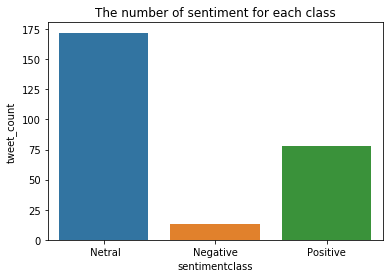

In [170]:
# Create a bar chart
ax = sns.barplot(x= 'sentimentclass', y='tweet_count', data=chart)
ax = ax.set_title('The number of sentiment for each class') 

#### 4.2. Pie Chart

(-1.1226482930209591,
 1.2541915479732924,
 -1.1147932035533026,
 1.1085237610981247)

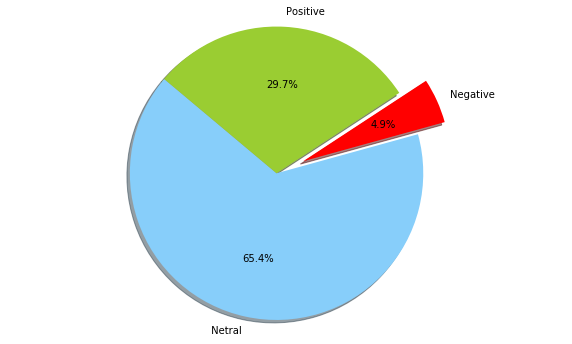

In [171]:
# Create a pie chart
colors = [ 'lightskyblue','red','yellowgreen']
explode = (0, 0.2, 0)  # explode 1st slice
# Plot
figure = plt.figure(figsize= (10,6))
plt.pie(chart['tweet_count'], explode=explode, labels=chart['sentimentclass'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

#### 4.3. Wordcloud

In [172]:
# Define positive, neutral and negative
positive = new_df.loc[new_df['sentimentclass'] == 'Positive']
neutral = new_df.loc[new_df['sentimentclass'] == ' Netral']
negative = new_df.loc[new_df['sentimentclass'] == 'Negative']

In [173]:
# Merge all the positive, neutral and negative comments into one paragraph
all_description_positive = "".join(positive.text.values)
all_description_neutral = "".join(neutral.text.values)
all_description_negative = "".join(negative.text.values)

In [174]:
# Create a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

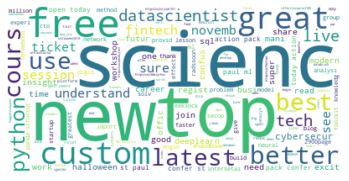

In [175]:
# Positive
create_word_cloud(all_description_positive)

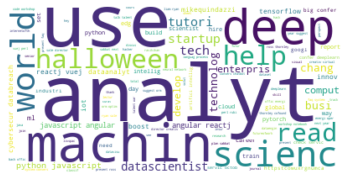

In [176]:
# Neutral
create_word_cloud(all_description_neutral)

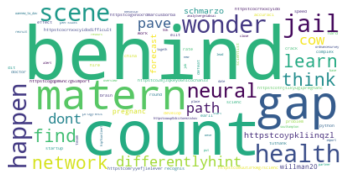

In [177]:
# Negative
create_word_cloud(all_description_negative)

## SECTION D: Feature Extraction

### 1. Count Vectorizer 

In [112]:
count_vectorizer = CountVectorizer(stop_words='english')

### 2. TF-IDF vectorizer 

In [113]:
tfidf = TfidfVectorizer(stop_words='english')

## SECTION E: Modeling 

### 1. Train Test Split

In [114]:
X = new_df['text']
y = new_df['sentimentclass']

In [115]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

In [116]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

In [117]:
## C. Modeling 

### 1. Train Test Split

X = new_df['text']
y = new_df['sentimentclass']

#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

### 2. Model Machine Learning

In [118]:
# a. Logistic regression
# b. Naive Bayes

#### a. Logistic Regression

In [119]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mikhael.bratanata\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [120]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

#### b. Naive Bayes

In [121]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [122]:
# TFIDFVectorizer
# from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

### 3. Model Evaluation

The following option are kind of model evaluation that used.  
- Precision = precision_score()
- Recall = recall_score() 
- F_measure = f1_score()

#### a. Logistic Regression

In [123]:
# Using count vectorizer
print("______________ Countvectorizer ______________")

# Lr_clf_vec_report_train = classification_report(train_y, Lr_pred_vect_train)
# Lr_clf_vec_report_test = classification_report(test_y, Lr_pred_vect_test)

# Lr_confmatrix_vect_train = confusion_matrix(train_y, Lr_pred_vect_train) 
# Lr_confmatrix_vect_test = confusion_matrix(test_y, Lr_pred_vect_test)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train, average="micro")
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test,average="micro") 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train,average="micro")
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test,average="micro")

print('Information :')
# print('Confusion matrix for Train :')
# print(Lr_confmatrix_vect_train,'\n')
# print('Confusion matrix for Test :')
# print(Lr_confmatrix_vect_test,'\n')
# print('Classification Refort for Train :')
# print(Lr_clf_vec_report_train,'\n')
# print('Classification Refort for Test :')
# print(Lr_clf_vec_report_test,'\n')
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 98.96% & 78.33%
Precision train & test  : 98.96% & 78.33%
F1 Score train & test   : 98.96% & 78.33%


In [124]:
# using count vectorizer
print("______________ TF-IDF ______________")


Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 72.50% & 64.17%
Precision train & test  : 72.50% & 64.17%
F1 Score train & test   : 72.50% & 78.33%


#### b. Naive Bayes

In [125]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")


NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Recall train & test     : 98.96% & 68.33%
Precision train & test  : 98.96% & 68.33%
F1 Score train & test   : 98.96% & 68.33%


In [126]:
# Using count vectorizer
print("______________ TF-IDF ______________")


NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Recall train & test     : 83.12% & 63.33%
Precision train & test  : 83.12% & 63.33%
F1 Score train & test   : 83.12% & 68.33%
